In [1]:
import gdown
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
customerCsv : str = "https://drive.google.com/file/d/1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE/view?usp=sharing"
productsCsv : str = "https://drive.google.com/file/d/1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0/view?usp=sharing"
transactionsCsv : str = "https://drive.google.com/file/d/1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF/view?usp=sharing"

In [3]:
def download_csv(url : str, outputPath : str) -> None:
  try:
    gdown.download(url, outputPath, quiet=False, fuzzy=True)
    print(f"File downloaded successfully and saved to {outputPath}")
  except Exception as e:
    print(f"Failed to dowload the file {e}")

In [4]:
download_csv(customerCsv, "/content/")
download_csv(productsCsv, "/content/")
download_csv(transactionsCsv, "/content/")

Downloading...
From: https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 22.9MB/s]


File downloaded successfully and saved to /content/


Downloading...
From: https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 3.72MB/s]


File downloaded successfully and saved to /content/


Downloading...
From: https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 70.4MB/s]

File downloaded successfully and saved to /content/


# Preprocessing

In [5]:
dfCustomers = pd.read_csv("/content/Customers.csv")
dfTransactions = pd.read_csv("/content/Transactions.csv")
dfProducts = pd.read_csv("/content/Products.csv")

In [6]:
transactions_products = pd.merge(dfTransactions, dfProducts, on='ProductID', how='left')
data = pd.merge(transactions_products, dfCustomers, on='CustomerID', how='left')
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


In [7]:
data.info()

missing_values = data.isnull().sum()

duplicates = data.duplicated().sum()

missing_values, duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   ProductName      1000 non-null   object 
 8   Category         1000 non-null   object 
 9   Price_y          1000 non-null   float64
 10  CustomerName     1000 non-null   object 
 11  Region           1000 non-null   object 
 12  SignupDate       1000 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


(TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price_x            0
 ProductName        0
 Category           0
 Price_y            0
 CustomerName       0
 Region             0
 SignupDate         0
 dtype: int64,
 0)

In [8]:
data_cleaned = data.drop(columns=["Price_y"])


data_cleaned["TransactionDate"] = pd.to_datetime(data_cleaned["TransactionDate"])
data_cleaned["SignupDate"] = pd.to_datetime(data_cleaned["SignupDate"])


customer_profiles = data_cleaned.groupby("CustomerID").agg({
    "ProductName": lambda x: " ".join(x),
    "Category": lambda x: " ".join(x),
    "TotalValue": "sum",
    "Quantity": "sum",
    "TransactionDate": ["count", "max"],
    "SignupDate": "first",
    "Region": "first"
}).reset_index()


customer_profiles.columns = [
    "CustomerID", "ProductName", "Category", "TotalValue",
    "TotalQuantity", "TransactionCount", "LastTransactionDate",
    "SignupDate", "Region"
]


customer_profiles["DaysSinceSignup"] = (
    pd.Timestamp.now() - customer_profiles["SignupDate"]
).dt.days

customer_profiles["DaysSinceLastTransaction"] = (
    pd.Timestamp.now() - customer_profiles["LastTransactionDate"]
).dt.days

print(customer_profiles.head())


  CustomerID                                        ProductName  \
0      C0001  SoundWave Cookbook HomeSense Wall Art SoundWav...   
1      C0002  BookWorld Cookware Set BookWorld Rug ComfortLi...   
2      C0003  ActiveWear Cookware Set ActiveWear Rug ActiveW...   
3      C0004  TechPro Textbook TechPro Rug TechPro Vase Acti...   
4      C0005  ActiveWear Cookware Set TechPro Smartwatch Com...   

                                            Category  TotalValue  \
0  Books Home Decor Electronics Electronics Elect...     3354.52   
1            Home Decor Home Decor Clothing Clothing     1862.74   
2         Home Decor Home Decor Clothing Electronics     2725.38   
3  Books Home Decor Home Decor Home Decor Books B...     5354.88   
4                 Home Decor Electronics Electronics     2034.24   

   TotalQuantity  TransactionCount LastTransactionDate SignupDate  \
0             12                 5 2024-11-02 17:04:16 2022-07-10   
1             10                 4 2024-12-03 01:4

In [9]:
customer_profiles["AveragePrice"] = customer_profiles["TotalValue"] / customer_profiles["TotalQuantity"]

def categorize_price(price):
    if price < 100:
        return "Low"
    elif 100 <= price <= 500:
        return "Mid"
    else:
        return "High"

customer_profiles["PriceTier"] = customer_profiles["AveragePrice"].apply(categorize_price)

price_tier_counts = customer_profiles.groupby(["CustomerID", "PriceTier"]).size().unstack(fill_value=0)

for tier in ["Low", "Mid", "High"]:
    if tier not in price_tier_counts.columns:
        price_tier_counts[tier] = 0

price_tier_proportions = price_tier_counts.div(price_tier_counts.sum(axis=1), axis=0).reset_index()
price_tier_proportions.columns = ["CustomerID", "LowTierProp", "MidTierProp", "HighTierProp"]

customer_profiles = customer_profiles.merge(price_tier_proportions, on="CustomerID", how="left")

customer_profiles.drop(columns=["PriceTier"], inplace=True, errors="ignore")

print(customer_profiles.head())

  CustomerID                                        ProductName  \
0      C0001  SoundWave Cookbook HomeSense Wall Art SoundWav...   
1      C0002  BookWorld Cookware Set BookWorld Rug ComfortLi...   
2      C0003  ActiveWear Cookware Set ActiveWear Rug ActiveW...   
3      C0004  TechPro Textbook TechPro Rug TechPro Vase Acti...   
4      C0005  ActiveWear Cookware Set TechPro Smartwatch Com...   

                                            Category  TotalValue  \
0  Books Home Decor Electronics Electronics Elect...     3354.52   
1            Home Decor Home Decor Clothing Clothing     1862.74   
2         Home Decor Home Decor Clothing Electronics     2725.38   
3  Books Home Decor Home Decor Home Decor Books B...     5354.88   
4                 Home Decor Electronics Electronics     2034.24   

   TotalQuantity  TransactionCount LastTransactionDate SignupDate  \
0             12                 5 2024-11-02 17:04:16 2022-07-10   
1             10                 4 2024-12-03 01:4

# Feature Engineering

In [10]:
customer_profiles["TextFeatures"] = customer_profiles["ProductName"] + " " + customer_profiles["Category"]

In [11]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

text_embeddings = sbert_model.encode(customer_profiles["TextFeatures"].tolist(), convert_to_tensor=False)

embedding_df = pd.DataFrame(text_embeddings, columns=[f"Embedding_{i}" for i in range(len(text_embeddings[0]))])

customer_profiles = pd.concat([customer_profiles, embedding_df], axis=1)

customer_profiles.to_csv("enhanced_customer_profiles_with_embeddings.csv", index=False)

print("Customer profiles updated with text embeddings and saved to 'enhanced_customer_profiles_with_embeddings.csv'.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Customer profiles updated with text embeddings and saved to 'enhanced_customer_profiles_with_embeddings.csv'.


In [12]:
customer_profiles["PurchaseFrequency"] = customer_profiles["TransactionCount"] / customer_profiles["DaysSinceSignup"]
customer_profiles["AverageSpendPerTransaction"] = customer_profiles["TotalValue"] / customer_profiles["TransactionCount"]

customer_profiles["PurchaseFrequency"] = customer_profiles["PurchaseFrequency"].fillna(0).replace([float("inf"), -float("inf")], 0)
customer_profiles["AverageSpendPerTransaction"] = customer_profiles["AverageSpendPerTransaction"].fillna(0).replace([float("inf"), -float("inf")], 0)

numerical_features = [
    "TotalValue",
    "TotalQuantity",
    "DaysSinceSignup",
    "DaysSinceLastTransaction",
    "PurchaseFrequency",
    "AverageSpendPerTransaction",
]

scaler = StandardScaler()
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

customer_profiles.to_csv("enhanced_customer_profiles_with_numerical_features.csv", index=False)

print("Numerical features engineered, standardized, and saved to 'enhanced_customer_profiles_with_numerical_features.csv'.")

Numerical features engineered, standardized, and saved to 'enhanced_customer_profiles_with_numerical_features.csv'.


# Modelling

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

customer_profiles = pd.read_csv("enhanced_customer_profiles_with_numerical_features.csv")

embedding_columns = [col for col in customer_profiles.columns if col.startswith("Embedding_")]
numerical_features = [
    "TotalValue",
    "TotalQuantity",
    "DaysSinceSignup",
    "DaysSinceLastTransaction",
    "PurchaseFrequency",
    "AverageSpendPerTransaction",
]

text_similarity = cosine_similarity(customer_profiles[embedding_columns])

numerical_data = customer_profiles[numerical_features].values
numerical_similarity = cosine_similarity(numerical_data)

TEXT_WEIGHT = 0.6
NUMERICAL_WEIGHT = 0.4
hybrid_similarity = (
    TEXT_WEIGHT * text_similarity + NUMERICAL_WEIGHT * numerical_similarity
)

customer_ids = customer_profiles["CustomerID"]
recommendations = {}

for i, customer_id in enumerate(customer_ids[:20]):
    similarities = list(enumerate(hybrid_similarity[i]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    top_3 = [(customer_ids[j], score) for j, score in similarities if customer_ids[j] != customer_id][:3]
    recommendations[customer_id] = top_3

recommendations_df = pd.DataFrame({
    "CustomerID": recommendations.keys(),
    "Recommendations": [str(recommendations[cust]) for cust in recommendations.keys()]
})

recommendations_df.to_csv("lookalike_recommendations.csv", index=False)

print("Lookalike recommendations saved to 'lookalike_recommendations.csv'.")

Lookalike recommendations saved to 'lookalike_recommendations.csv'.


# Recommendations

In [14]:
first_20_customers = customer_ids[:20]

recommendations_for_20 = {}

for i, customer_id in enumerate(first_20_customers):
    similarities = list(enumerate(hybrid_similarity[i]))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    top_3 = [(customer_ids[j], round(score, 4)) for j, score in similarities if customer_ids[j] != customer_id][:3]
    recommendations_for_20[customer_id] = top_3

lookalike_map = [{"cust_id": cust, "lookalikes": recommendations_for_20[cust]} for cust in recommendations_for_20]

import csv

with open("Lookalike.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["cust_id", "lookalikes"])
    for entry in lookalike_map:
        writer.writerow([entry["cust_id"], entry["lookalikes"]])

print("Top-3 recommendations for the first 20 customers saved to 'Lookalike.csv'.")

Top-3 recommendations for the first 20 customers saved to 'Lookalike.csv'.


# Evaluation

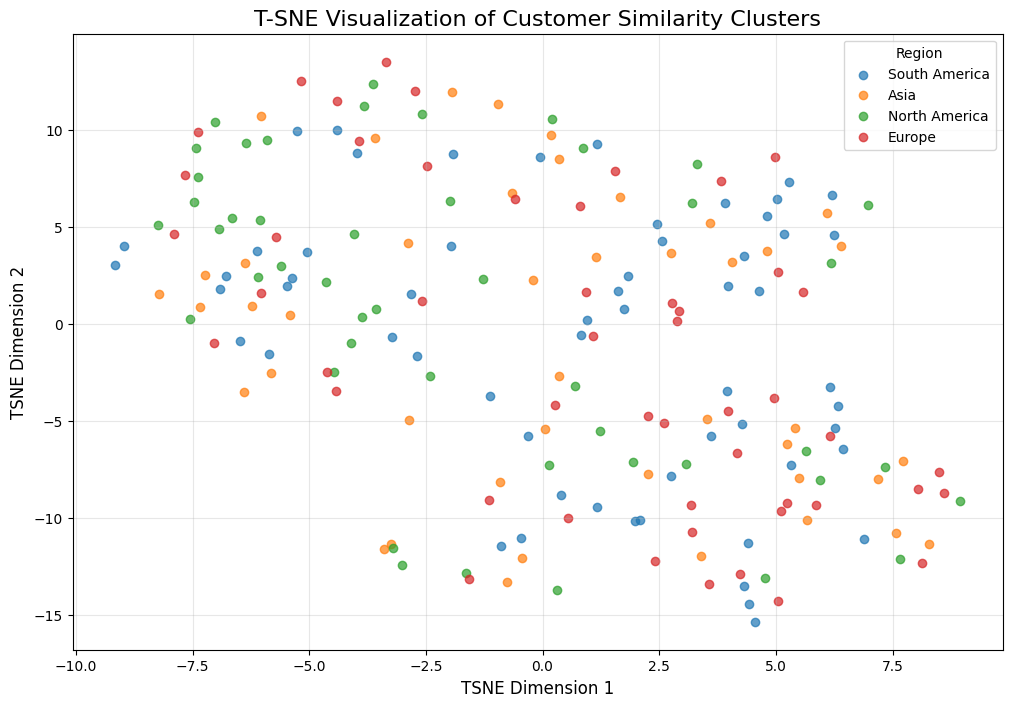

T-SNE visualization completed. Profiles saved to 'customer_profiles_with_tsne.csv'.


In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embedding_columns = [col for col in customer_profiles.columns if col.startswith("Embedding_")]
numerical_features = [
    "TotalValue",
    "TotalQuantity",
    "DaysSinceSignup",
    "DaysSinceLastTransaction",
    "PurchaseFrequency",
    "AverageSpendPerTransaction",
]

combined_features = np.hstack([
    customer_profiles[embedding_columns].values,
    customer_profiles[numerical_features].values
])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_features = tsne.fit_transform(combined_features)

customer_profiles["TSNE_X"] = reduced_features[:, 0]
customer_profiles["TSNE_Y"] = reduced_features[:, 1]

plt.figure(figsize=(12, 8))
for region in customer_profiles["Region"].unique():
    subset = customer_profiles[customer_profiles["Region"] == region]
    plt.scatter(
        subset["TSNE_X"],
        subset["TSNE_Y"],
        label=region,
        alpha=0.7
    )

plt.title("T-SNE Visualization of Customer Similarity Clusters", fontsize=16)
plt.xlabel("TSNE Dimension 1", fontsize=12)
plt.ylabel("TSNE Dimension 2", fontsize=12)
plt.legend(title="Region")
plt.grid(alpha=0.3)
plt.show()

customer_profiles.to_csv("customer_profiles_with_tsne.csv", index=False)
print("T-SNE visualization completed. Profiles saved to 'customer_profiles_with_tsne.csv'.")